# Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import nbinom
import scipy.stats as stats
import itertools
from scipy import spatial
from collections import namedtuple
from collections import deque
import copy
from math import trunc
import math

import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import random

from datetime import datetime, timedelta

import os

from dataclasses import dataclass

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")

# Problem simulations

## Synthetic benchmark

In [2]:
# ============================================================
#  Arm-Intercept Logistic Contextual Bandit (A-ILCB)
# ============================================================

class AILCBanditEnv:
    """
    Arm-Intercept Logistic Contextual Bandit (A-ILCB).

    Context x ~ N(0, I_d).
    For arm a, reward r ∈ {0,1} with
        P(r=1 | x, a) = sigmoid( alpha[a] + x^T beta ),
    where alpha[a] ~ N(0, sigma_alpha^2) (unknown arm quality),
          beta      ~ N(0, (1/d) I)      (weak context slope shared across arms).
    """

    def __init__(
        self,
        n_arms: int = 10,
        context_dim: int = 5,
        structure: str = "logistic",   # accepted for API compatibility
        noise_std: float = 1.0,        # accepted for API compatibility
        random_state: int = None
    ):
        self.random_state = np.random.RandomState(random_state)
        self.n_arms = int(n_arms)
        self.context_dim = int(context_dim)

        # ---- hyperparameters (tweak if needed) ----
        self.sigma_alpha = 1.0   # arm-intercept std
        target = 0.4 * self.sigma_alpha
        
        #self.beta_scale  = 1.0 / max(1, self.context_dim)  # weak shared slope prior

        # Draw shared context slope and per-arm intercepts
        self.beta = self.random_state.randn(self.context_dim) 
        self.beta *= target / np.linalg.norm(self.beta)
        self.alpha = self.random_state.randn(self.n_arms) * self.sigma_alpha

        # Cache last context
        self.current_context = None

    def get_nr_arms(self):
        return self.n_arms

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def get_context(self):
        x = self.random_state.randn(self.context_dim)
        self.current_context = x
        return x

    def get_reward(self, action, context):
        """
        Sample Bernoulli reward (float 0.0 or 1.0).
        """
        lin = self.alpha[int(action)] + float(np.dot(self.beta, context))
        p = self._sigmoid(lin)
        return float(self.random_state.rand() < p)

    def get_all_rewards(self, context):
        """
        Return expected reward (click prob) for each arm under the given context.
        """
        lin = self.alpha + np.dot(self.beta, context)
        return self._sigmoid(lin)

## Seat pricing simulation

In [3]:
# =========================================
# Environment: Multi-armed bandit simulator
# =========================================

class MultiArmedBandit:
    """
    Multi-armed bandit with optional context.

    Supports:
      - 'bernoulli'
      - 'normal'    (placeholder)
      - 'pricing_poisson_offline' : seat pricing with Poisson demand via shared theta (true environment),
        with discrete contexts (e.g., 0='leisure', 1='business').
    """

    def __init__(
        self,
        num_bandits: int,
        probs: np.ndarray,
        payouts: np.ndarray,
        bandit_type: str,
        contextual: bool = False,
        context_function=None,
        # --- pricing params ---
        prices: np.ndarray = None,
        theta_true: np.ndarray = None,
        phi_function=None,
        context_grid: np.ndarray = None,
        context_transition_true: np.ndarray = None,
        rng: np.random.Generator = None,
    ):
        self.num_bandits = num_bandits
        self.type = bandit_type.lower()
        self.probs = probs
        self.payouts = payouts
        self.contextual = contextual
        self.context_function = context_function if context_function is not None else (lambda i, c: probs[i])

        # Pricing bits
        self.prices = prices
        self.theta_true = theta_true
        self.phi_function = phi_function
        self.context_grid = context_grid
        self.context_transition_true = context_transition_true
        self.rng = rng if rng is not None else np.random.default_rng()

        # Cache last context, start with random initialisation
        self.current_context = np.random.choice(context_grid)

        if self.type == "pricing_poisson_offline":
            if self.prices is None or self.theta_true is None or self.phi_function is None:
                raise ValueError("pricing_poisson_offline requires prices, theta_true, phi_function.")
            if self.context_grid is None:
                raise ValueError("pricing_poisson_offline requires a discrete context_grid (e.g., [0,1]).")
            if self.context_transition_true is None:
                C = len(self.context_grid)
                self.context_transition_true = np.ones((C, C), dtype=float)
                self.context_transition_true /= self.context_transition_true.sum(axis=1, keepdims=True)

    def _context_index(self, c_val):
        return int(np.argmin(np.abs(self.context_grid - c_val)))

    def sample_next_context(self, current_context):
        ci = self._context_index(current_context)
        probs = self.context_transition_true[ci]
        next_idx = self.rng.choice(len(self.context_grid), p=probs)
        return self.context_grid[next_idx]

    def get_context(self):
        x = self.sample_next_context(self.current_context)
        self.current_context = x
        return x

    def reset(self):
        # New environment instance per episode (true θ, kernel fixed for comparability).
        if self.type == "bernoulli":
            self.probs = np.random.rand(self.num_bandits)
        elif self.type == "normal":
            pass
        elif self.type == "pricing_poisson_offline":
            pass
        else:
            self.probs = np.random.rand(self.num_bandits)

    def get_reward(self, action: int, context: float):
        return self.pull(action, context)

    def pull(self, i: int, context: float = None):
        """
        Return reward for action i at context.
        - bernoulli: 0/1
        - pricing_poisson_offline: revenue = price * seats, seats ~ Poisson(exp(phi^T theta_true))
        """
        if self.type == "bernoulli":
            eff = self.context_function(i, context) if (self.contextual and context is not None) else self.probs[i]
            return 1 if np.random.random() < eff else 0

        elif self.type == "normal":
            return self.probs[i].rvs()  # if frozen dists

        elif self.type == "pricing_poisson_offline":
            if context is None:
                raise ValueError("pricing_poisson_offline requires a discrete context value.")
            price = float(self.prices[i])
            x = self.phi_function(context, price)
            lam = float(np.exp(x @ self.theta_true))
            seats = int(np.random.poisson(lam))
            return price * seats

        else:
            return 1 if np.random.random() < self.probs[i] else 0


    def get_all_rewards(self, context: float):
        """
        Return the vector of expected rewards for each arm given the current context.
        - pricing_poisson_offline: E[revenue | c, p] = p * E[seats | c, p] = p * exp(phi(c,p) · theta_true)
        - bernoulli: expected reward per arm (optionally scaled by payouts if provided)
        For other types, extend as needed.
        """
        if self.type == "pricing_poisson_offline":
            if context is None:
                raise ValueError("pricing_poisson_offline requires a discrete context value.")
            prices = np.asarray(self.prices, dtype=float)
            theta = np.asarray(self.theta_true, dtype=float).reshape(-1)
            exp_rewards = np.empty_like(prices, dtype=float)
    
            # Call phi_function with a scalar price per arm
            for j, p in enumerate(prices):
                x = np.asarray(self.phi_function(context, float(p)), dtype=float).reshape(-1)  # feature vector
                lam = float(np.exp(x @ theta))  # Poisson mean
                exp_rewards[j] = float(p) * lam  # expected revenue
            return exp_rewards
    
        elif self.type == "bernoulli":
            # Expected reward = success prob (× payout if provided)
            probs = np.array([
                self.context_function(i, context) if (self.contextual and context is not None) else self.probs[i]
                for i in range(self.num_bandits)
            ], dtype=float)
            return probs * np.array(self.payouts, dtype=float) if self.payouts is not None else probs
    
        else:
            raise NotImplementedError(f"get_all_rewards not implemented for bandit_type='{self.type}'")

## Helper functions

In [4]:
def run_contextual_bandit(agent, mab, context_grid, episodes=40, episode_length=150, initial_context=None, random_start=True):
    """
    Runs multiple episodes and returns average reward per round (fair resets).
    """
    avg_rewards_per_round = np.zeros(episode_length, dtype=float)

    for _ in range(episodes):
        mab.reset()
        agent.reset()

        current_context = (
            np.random.choice(context_grid) if (initial_context is None and random_start) else
            (context_grid[0] if initial_context is None else initial_context)
        )

        ep_rewards = []
        for t in range(episode_length):
            a = agent.choose(context=current_context)
            r = mab.pull(a, context=current_context)
            new_context = mab.sample_next_context(current_context) if hasattr(mab, "sample_next_context") else current_context

            agent.process_choice(a, r, context=current_context, new_context=new_context)
            #agent.update_context_transition(current_context, new_context)

            current_context = new_context
            ep_rewards.append(r)

        avg_rewards_per_round += np.array(ep_rewards, dtype=float)

    avg_rewards_per_round /= float(episodes)
    return avg_rewards_per_round

def get_average_rewards(rewards):
    t = np.array(rewards)
    nr_episodes = len(rewards[0])
    samples_per_episode = len(rewards)
    averages = np.zeros(nr_episodes)
    for i in range(nr_episodes):
        averages[i] = np.mean(t[:,i])
        #averages[i] = sum(t[i,:]) / count
    return averages

def get_mean_std_rewards(rewards):
    """
    Computes the mean and standard deviation for each simulation round.
    
    Parameters:
      rewards: A 2D array-like object of shape (num_simulations, num_rounds)
      
    Returns:
      means: A 1D array of mean rewards per round.
      stds: A 1D array of standard deviations per round.
    """
    data = np.array(rewards)
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    quantiles = np.percentile(data, 15, axis=0)
    return means, stds

In [5]:
def _action_to_index(env, action):
    """Map action to an integer arm index, robust to price values or 1-element arrays."""
    if isinstance(action, (list, np.ndarray)) and np.size(action) == 1:
        action = float(np.asarray(action).reshape(-1)[0])
    if np.isscalar(action):
        a = float(action)
        if a.is_integer():
            idx = int(a)
            if hasattr(env, "prices") and env.prices is not None:
                if 0 <= idx < len(env.prices):
                    return idx
            else:
                return idx
        if hasattr(env, "prices") and env.prices is not None:
            match = np.where(np.isclose(np.asarray(env.prices, float), a))[0]
            if match.size > 0:
                return int(match[0])
    # Fallback: assume already an index
    try:
        return int(action)
    except Exception as e:
        raise ValueError(f"Cannot map action {action!r} to index") from e

In [6]:
def run_bandits(
    env,
    agents,
    n_rounds: int = 1000,
    n_simulations: int = 10,
    title: str = "",
    regret_mode: str = "realized",   # "realized" | "expected"
    save_prefix: str | None = None,
    error_style: str = "standard-deviation",  # "standard-deviation" | "standard-error" | "confidence-interval"
):
    """
    Run bandit simulation(s) for each agent and report final cumulative regret.

    regret_mode:
      - "realized": per-round regret = max_a E[r|c,a] - r_observed
      - "expected": per-round regret = max_a E[r|c,a] - E[r|c,a_t]  (non-negative)

    error_style controls error bars on the bar chart:
      - "standard-deviation"  : yerr = SD across simulations (symmetric)
      - "standard-error"      : yerr = SD / sqrt(n) (symmetric)
      - "confidence-interval" : yerr = empirical 95% CI via percentiles (asymmetric)
    """
    # normalize error_style
    es = error_style.strip().lower().replace("_", "-")
    if es in {"sd"}: es = "standard-deviation"
    if es in {"se"}: es = "standard-error"
    if es in {"ci", "95ci", "confidence", "95%-ci"}: es = "confidence-interval"
    if es not in {"standard-deviation", "standard-error", "confidence-interval"}:
        raise ValueError("error_style must be one of {'standard-deviation','standard-error','confidence-interval'}")

    results = {}

    for agent in agents:
        start_run_time = datetime.now()
        final_cum_regrets = []
        final_cum_rewards = []

        for sim in range(n_simulations):
            if hasattr(agent, "reset"):
                agent.reset()

            cumulative_reward = 0.0
            regret_sum = 0.0
            current_context = env.get_context()

            for t in range(n_rounds):
                action = agent.get_action(current_context)
                reward = env.get_reward(action, current_context)
                cumulative_reward += reward

                # Expected rewards for each arm under current context
                all_rewards = env.get_all_rewards(current_context)

                if regret_mode == "expected":
                    action_idx = _action_to_index(env, action)
                    best_expected = float(np.max(all_rewards))
                    expected_alg = float(all_rewards[action_idx])
                    regret_sum += (best_expected - expected_alg)
                else:
                    best_expected = float(np.max(all_rewards))
                    regret_sum += (best_expected - float(reward))

                # Advance env context; feed data back to agent
                new_context = env.get_context()
                try:
                    agent.process_data(bandit_index=_action_to_index(env, action),
                                       reward=reward,
                                       context=current_context,
                                       new_context=new_context)
                except TypeError:
                    try:
                        agent.process_data(action, current_context, reward)
                    except TypeError:
                        agent.process_data(action, reward)
                current_context = new_context

            final_cum_regrets.append(regret_sum)
            final_cum_rewards.append(cumulative_reward)

        end_run_time = datetime.now()
        total_run_time = end_run_time - start_run_time

        regrets_arr = np.asarray(final_cum_regrets, dtype=float)
        mean_regret = float(np.mean(regrets_arr))
        # sample SD (ddof=1); falls back to 0 if n=1
        std_regret = float(np.std(regrets_arr, ddof=1)) if len(regrets_arr) > 1 else 0.0
        n = max(1, n_simulations)

        # compute yerr (possibly asymmetric)
        if es == "standard-deviation":
            low_err = std_regret
            up_err  = std_regret
        elif es == "standard-error":
            se = std_regret / np.sqrt(n)
            low_err = se
            up_err  = se
        else:  # "confidence-interval" → empirical percentile CI
            if len(regrets_arr) > 1:
                lower = float(np.percentile(regrets_arr, 2.5))
                upper = float(np.percentile(regrets_arr, 97.5))
                low_err = max(0.0, mean_regret - lower)
                up_err  = max(0.0, upper - mean_regret)
            else:
                low_err = 0.0
                up_err  = 0.0

        alg_name = agent.get_name() if hasattr(agent, "get_name") else getattr(agent, "name", type(agent).__name__)
        results[alg_name] = {
            "avg_cumulative_reward": float(np.mean(final_cum_rewards)),
            "avg_final_regret": mean_regret,
            "std_final_regret": std_regret,
            "yerr_low": low_err,
            "yerr_up": up_err,
            "run_time": total_run_time,
            "regret_mode": regret_mode,
            "error_style": es,
            "n": n,
        }

    # Prepare plot data
    alg_names  = list(results.keys())
    avg_regrets = [results[nm]["avg_final_regret"] for nm in alg_names]
    yerr_low    = np.array([results[nm]["yerr_low"] for nm in alg_names], dtype=float)
    yerr_up     = np.array([results[nm]["yerr_up"]  for nm in alg_names], dtype=float)
    run_times   = [results[nm]["run_time"] for nm in alg_names]

    # Matplotlib expects shape (2, N) for asymmetric error bars
    yerr = np.vstack([yerr_low, yerr_up])

    print(f"Algorithms: {alg_names}")
    print(f"Average regrets: {avg_regrets}")
    if es == "confidence-interval":
        ci_lo = (np.array(avg_regrets) - yerr_low).tolist()
        ci_hi = (np.array(avg_regrets) + yerr_up ).tolist()
        print(f"95% empirical CI lower: {ci_lo}")
        print(f"95% empirical CI upper: {ci_hi}")
    else:
        print(f"Error bars ({es}): lower={yerr_low.tolist()} upper={yerr_up.tolist()}")
    print(f"Run times: {run_times}")

    plt.figure(figsize=(10, 6))
    x = np.arange(len(alg_names))
    plt.bar(x, avg_regrets, yerr=yerr, capsize=5, alpha=0.7)
    plt.xticks(x, alg_names, rotation=45, ha="right")
    plt.xlabel("Algorithm")
    ylabel = "Average Final Cumulative Expected Regret" if regret_mode == "expected" \
             else "Average Final Cumulative Realized Regret"
    label_es = {"standard-deviation":"SD", "standard-error":"SE", "confidence-interval":"95% CI"}[es]
    plt.ylabel(f"{ylabel}  (error: {label_es})")
    plt.title(f"{title}Average Final Cumulative Regret over {results[alg_names[0]]['n']} Simulations\n({n_rounds} rounds each)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    if save_prefix:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(f"{save_prefix}_{timestamp}.png", dpi=150)

    plt.show()
    return results

In [7]:
_colour_palette = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00", "#999999"]

def collect_cumulative_expected_regret(env, agents, n_rounds=500, n_simulations=50):
    """
    Returns dict: name -> array of shape (n_simulations, n_rounds)
    with cumulative expected regret per round.
    """
    out = {}
    for agent in agents:
        if hasattr(agent, "get_name"):
            name = agent.get_name()
        else:
            name = getattr(agent, "name", type(agent).__name__)
        R = np.zeros((n_simulations, n_rounds), dtype=float)

        for s in range(n_simulations):
            if hasattr(agent, "reset"):
                agent.reset()
            ctx = env.get_context()
            cum = 0.0
            for t in range(n_rounds):
                a = agent.get_action(ctx)
                r = env.get_reward(a, ctx)

                all_rewards = env.get_all_rewards(ctx)      # expected rewards per arm
                idx = _action_to_index(env, a)
                best = float(np.max(all_rewards))
                alg  = float(all_rewards[idx])
                cum += (best - alg)                         # expected regret this round
                R[s, t] = cum

                new_ctx = env.get_context()
                # feed back data (be tolerant to signatures)
                try:
                    agent.process_data(a, ctx, r)
                except TypeError:
                    try:
                        agent.process_data(bandit_index=_action_to_index(env, a),
                                           reward=r, context=ctx, new_context=new_ctx)
                    except TypeError:
                        agent.process_data(a, r)
                ctx = new_ctx
        out[name] = R
    return out

In [8]:
def plot_learning_curves_with_ci(curves_dict,
                                 show_only=None,            # list of names to plot
                                 highlight=None,            # name to emphasize
                                 band_type="ci",            # "none" | "se" | "ci" | "iqr"
                                 bands_for="highlight",     # "highlight" | "all" | "none"
                                 smooth_window=0,           # e.g., 7
                                 ylabel="Cumulative expected regret",
                                 title=None,
                                 legend_out=True,
                                 save_prefix:str | None = None):
    """
    curves_dict: name -> array (n_sim, n_rounds) of cumulative expected regret.
    band_type:
      - "ci"  : empirical 95% CI (2.5–97.5 pct)
      - "se"  : mean ± 1 SE
      - "iqr" : 25–75 pct band
      - "none": no band
    bands_for:
      - "highlight": only draw band for 'highlight'
      - "all"      : bands for all methods
      - "none"     : no bands at all
    """

    colour_palette = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00", "#999999"]

    plt.figure(figsize=(7.2, 4.2))
    names = list(curves_dict.keys())
    if show_only is not None:
        names = [n for n in names if n in show_only]

    for i, name in enumerate(names):
        R = curves_dict[name]  # (n_sim, T)
        mean = R.mean(axis=0)

        if band_type == "ci":
            lo   = np.percentile(R, 2.5, axis=0)
            hi   = np.percentile(R, 97.5, axis=0)
        elif band_type == "se":
            se   = R.std(axis=0, ddof=1) / np.sqrt(max(1, R.shape[0]))
            lo   = mean - se
            hi   = mean + se
        elif band_type == "iqr":
            lo   = np.percentile(R, 25, axis=0)
            hi   = np.percentile(R, 75, axis=0)
        else:
            lo = hi = None  # no band

        if smooth_window and smooth_window > 1:
            k = smooth_window
            w = np.ones(k) / k
            mean = np.convolve(mean, w, mode="same")
            if lo is not None:
                lo = np.convolve(lo, w, mode="same")
                hi = np.convolve(hi, w, mode="same")

        colour = colour_palette[i % len(colour_palette)]
        lw    = 2.6 if (highlight and name == highlight) else 1.6
        alpha_line = 1.0 if (highlight and name == highlight) else 0.9
        alpha_band = 0.18 if (highlight and name == highlight) else 0.10

        x = np.arange(R.shape[1])

        draw_band = (band_type != "none") and (
            (bands_for == "all") or (bands_for == "highlight" and highlight and name == highlight)
        )
        if draw_band and lo is not None:
            plt.fill_between(x, lo, hi, color=colour, alpha=alpha_band, linewidth=0)

        plt.plot(x, mean, color=colour, lw=lw, alpha=alpha_line, label=name)

    plt.xlabel("Round")
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if legend_out:
        plt.legend(frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.18), loc="upper center")
        plt.gcf().subplots_adjust(bottom=0.25)
    else:
        plt.legend(frameon=False)
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    if save_prefix:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(f"{save_prefix}_{timestamp}.png", dpi=150)
    plt.show()

In [9]:
def save_rewards_chart_over_time(chart_data, chart_titles, chart_name):
    fig, ax = plt.subplots()
    for i in range(len(chart_data)):
        plt.plot(chart_data[i], label=chart_titles[i], linewidth=0.75)
    
    plt.legend()
    plt.title(chart_name)
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Reward")
    fig.savefig("charts/" + chart_name + ".png")
    plt.close(fig)


def show_rewards_chart_over_time(chart_data, chart_titles, chart_name):
    fig, ax = plt.subplots()
    for i in range(len(chart_data)):
        plt.plot(chart_data[i], label=chart_titles[i], linewidth=0.75)
    
    plt.legend()
    plt.title(chart_name)

def show_rewards_chart_with_shading(chart_data, chart_titles, chart_name):
    """
    Plots the average reward over time for each algorithm, adding a shaded area representing
    variability (standard deviation).
    
    Parameters:
      chart_data: List of reward arrays for each algorithm, where each array has shape (num_simulations, num_rounds)
      chart_titles: List of algorithm names (for the legend)
      chart_name: Title for the chart
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    rounds = np.arange(chart_data[0].shape[1])
    
    for i in range(len(chart_data)):
        means, stds = get_mean_std_rewards(chart_data[i])
        ax.plot(rounds, means, label=chart_titles[i], linewidth=0.75)
        stds = stds / 6
        ax.fill_between(rounds, means - stds, means + stds, alpha=0.2)
    
    ax.legend()
    ax.set_title(chart_name)
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Reward")
    plt.show()

def show_rewards_chart_with_errorbars(chart_data, chart_titles, chart_name, interval=50):
    """
    Plots the average reward over time for each algorithm, adding error bars at specified intervals.
    
    Parameters:
      chart_data: List of reward arrays for each algorithm, shape: (num_simulations, num_rounds)
      chart_titles: List of algorithm names (for the legend)
      chart_name: Title for the chart
      interval: The interval (in rounds) at which error bars are drawn.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    rounds = np.arange(chart_data[0].shape[1])
    
    for i in range(len(chart_data)):
        means, stds = get_mean_std_rewards(chart_data[i])
        #ax.plot(rounds, means, label=chart_titles[i], linewidth=0.75)
        # Plot error bars at every 'interval' rounds
        error_rounds = rounds[::interval]
        error_means = means[::interval]
        error_stds = stds[::interval] / 8
        ax.errorbar(error_rounds, error_means, yerr=error_stds, label=chart_titles[i], fmt='o', markersize=3, capsize=3)
    
    ax.legend()
    ax.set_title(chart_name)
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Reward")
    plt.show()

In [10]:
def get_warmup_samples(env, num_samples_per_arm):
    results = {}
    results['context'] = []
    results['reward'] = []
    results['arm'] = []
    for arm in range(env.n_arms):
        for _ in range(num_samples_per_arm):
            context = env.get_context()
            reward = env.get_reward(arm, context)
            results['context'].append(context)
            results['reward'].append(reward)
            results['arm'].append(arm)

    results['context'] = np.array(results['context'])
    results['reward'] = np.array(results['reward'])
    results['arm'] = np.array(results['arm'])
    return results

# Benchmark algorithms

In [11]:
class EpsilonGreedy:
    def __init__(self, num_bandits: int, eps=0.05, alpha=1.0, context_grid: np.ndarray = None):
        """
        If context_grid is provided, the algorithm is contextual and wins/pulls are tracked per context.
        """
        self.name = "Epsilon Greedy"
        self.num_bandits = num_bandits
        self.initial_eps = eps
        self.eps = eps
        self.alpha = alpha
        self.choices = []
        
        if context_grid is not None:
            self.contextual = True
            self.context_grid = context_grid
            self.num_contexts = len(context_grid)
            # wins and pulls are now matrices: (num_bandits, num_contexts)
            self.wins = np.zeros((num_bandits, self.num_contexts))
            self.pulls = np.zeros((num_bandits, self.num_contexts))
        else:
            self.contextual = False
            self.wins = np.zeros(num_bandits)
            self.pulls = np.zeros(num_bandits)
        
    def reset(self):
        self.choices = []
        self.eps = self.initial_eps
        if self.contextual:
            self.wins = np.zeros((self.num_bandits, self.num_contexts))
            self.pulls = np.zeros((self.num_bandits, self.num_contexts))
        else:
            self.wins = np.zeros(self.num_bandits)
            self.pulls = np.zeros(self.num_bandits)

    def update_context_transition(self, old_context, new_context):
        pass
        
    def _get_context_index(self, context: float) -> int:
        """
        Returns the index of the context value in the context_grid (using nearest neighbor).
        """
        return int(np.argmin(np.abs(self.context_grid - context)))
    
    def max_mean(self, context: float):
        """
        Returns the arm index with the highest estimated mean reward for the given context.
        """
        idx = self._get_context_index(context)
        # Compute average reward for each arm in this context.
        averages = self.wins[:, idx] / (self.pulls[:, idx] + 0.1)
        return int(np.argmax(averages))

    def get_action(self, context):
        return self.choose(context)
    
    def choose(self, context: float = None):
        """
        Choose an arm based on epsilon-greedy strategy.
        For the contextual version, a context value must be provided.
        """
        if self.contextual:
            if context is None:
                raise ValueError("Context must be provided in contextual epsilon-greedy.")
            idx = self._get_context_index(context)
            r = np.random.rand()
            best = self.max_mean(context)
            if r < self.eps:
                # Explore: choose randomly from arms that are not the best.
                candidates = list(set(range(self.num_bandits)) - {best})
                # If all arms are equally good (or only one arm exists), fall back to best.
                return np.random.choice(candidates) if candidates else best
            else:
                return best
        else:
            # Non-contextual epsilon-greedy.
            r = np.random.rand()
            best = int(self.max_mean(0))  # Dummy context index 0.
            if r < self.eps:
                candidates = list(set(range(len(self.wins))) - {best})
                return np.random.choice(candidates) if candidates else best
            else:
                return best

    def process_data(self, bandit_index, reward, context, new_context):
        return self.process_choice(bandit_index, reward, context, new_context)
        
    def process_choice(self, choice, payout, context: float = None, new_context: float = None):
        """
        Update the wins and pulls for the chosen arm.
        For the contextual version, the update is applied for the corresponding context.
        """
        if self.contextual:
            if context is None:
                raise ValueError("Context must be provided when processing a choice in contextual epsilon-greedy.")
            idx = self._get_context_index(context)
            self.pulls[choice, idx] += 1
            self.wins[choice, idx] += payout
            self.choices.append(choice)
        else:
            self.pulls[choice] += 1
            self.wins[choice] += payout
            self.choices.append(choice)
        self.eps *= self.alpha
        
    def print_average_reward(self):
        if self.contextual:
            total_wins = np.sum(self.wins)
            total_pulls = np.sum(self.pulls)
        else:
            total_wins = float(np.sum(self.wins))
            total_pulls = float(np.sum(self.pulls))
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        if total_pulls > 0:
            print("Average reward:", total_wins / total_pulls)
        else:
            print("Average reward: 0")

    def get_name(self):
        return self.name

In [12]:
class ContextualThompsonSampling:
    def __init__(self, num_bandits: int, context_grid: np.ndarray = None):
        """
        Contextual Thompson Sampling for Bernoulli bandits.
        
        Parameters:
        - num_bandits: Number of arms.
        - context_grid: 1D array of discretized context values. If not provided,
                        the algorithm defaults to a non-contextual version.
        """
        self.name = "ContextualTS"
        self.num_bandits = num_bandits
        self.contextual = context_grid is not None
        # If no context grid is provided, treat it as non-contextual by using a single dummy context.
        self.context_grid = context_grid if context_grid is not None else np.array([0])
        self.num_contexts = len(self.context_grid)
        
        # Initialize Beta parameters for each arm and each discretized context.
        self.alphas = np.ones((num_bandits, self.num_contexts))
        self.betas = np.ones((num_bandits, self.num_contexts))
        
        # For diagnostics and reward tracking.
        self.choices = []
        self.wins = np.zeros((num_bandits, self.num_contexts))
        self.pulls = np.zeros((num_bandits, self.num_contexts))
    
    def reset(self):
        self.choices = []
        self.alphas = np.ones((self.num_bandits, self.num_contexts))
        self.betas = np.ones((self.num_bandits, self.num_contexts))
        self.wins = np.zeros((self.num_bandits, self.num_contexts))
        self.pulls = np.zeros((self.num_bandits, self.num_contexts))

    def update_context_transition(self, context_old: float, context_new: float):
        """
        Update the online estimator for context transitions.
        context_old and context_new are the observed context values.
        """
        pass
    
    def _get_context_index(self, context: float) -> int:
        """
        Returns the index in the context grid that is closest to the provided context value.
        """
        return int(np.argmin(np.abs(self.context_grid - context)))

    def get_action(self, context):
        return self.choose(context)
    
    def choose(self, context: float = None):
        """
        Choose an arm based on sampling from the Beta distributions corresponding to the given context.
        For the contextual version, a context value must be provided.
        """
        if self.contextual:
            if context is None:
                raise ValueError("Context must be provided for contextual Thompson Sampling.")
            idx = self._get_context_index(context)
        else:
            idx = 0  # Non-contextual: use dummy index 0.
        
        # Sample a success probability from the Beta distribution for each arm at the given context.
        samples = np.array([beta.rvs(self.alphas[i, idx], self.betas[i, idx]) for i in range(self.num_bandits)])
        return int(np.argmax(samples))

    def process_data(self, bandit_index, reward, context, new_context):
        return self.process_choice(bandit_index, reward, context, new_context)
    
    def process_choice(self, choice, payout, context: float, new_context: float = None):
        """
        Update the Beta parameters for the chosen arm in the appropriate context.
        """
        if self.contextual:
            idx = self._get_context_index(context)
        else:
            idx = 0
        self.pulls[choice, idx] += 1
        self.wins[choice, idx] += payout
        self.choices.append(choice)
        if payout == 1:
            self.alphas[choice, idx] += 1
        else:
            self.betas[choice, idx] += 1
    
    def print_average_reward(self):
        total_wins = np.sum(self.wins)
        total_pulls = np.sum(self.pulls)
        print("Total pulls:", total_pulls)
        print("Total wins:", total_wins)
        if total_pulls > 0:
            print("Average reward:", total_wins / total_pulls)
        else:
            print("Average reward: 0")

    def get_name(self):
        return self.name


In [13]:
# ---------------------------------------------------------------------
# LinUCB: Linear Upper‐Confidence‐Bound
# ---------------------------------------------------------------------
class LinUCB:
    def __init__(self, arms: list, context_dim: int = 1, alpha: float = 1.0, lam: float = 1.0):
        """
        :param arms: list of arm identifiers (e.g. numeric)
        :param context_dim: dimension of the context vector
        :param alpha: exploration parameter (larger → more exploration)
        :param lam: ridge regularization parameter
        """
        self.name = "LinUCB"
        #self.arms = np.array(arms, dtype=np.float64)
        self.arms = np.array(arms)
        self.context_dim = context_dim
        self.feature_dim = 1 + context_dim + 1  # [1] ⊕ context ⊕ [arm]
        self.alpha = alpha
        self.lam = lam
        self.reset()

    def reset(self):
        # A = λ I, b = 0
        self.A = self.lam * np.eye(self.feature_dim)
        self.b = np.zeros(self.feature_dim)

    def feature(self, context, arm):
        c = np.array(context).flatten()
        return np.concatenate(([1.0], c, [arm]))

    def choose(self, context):
        A_inv = np.linalg.inv(self.A)
        theta_hat = A_inv.dot(self.b)
        # compute UCB score for each arm
        scores = []
        for arm in self.arms:
            φ = self.feature(context, arm)
            mean = φ.dot(theta_hat)
            var = φ.dot(A_inv.dot(φ))
            scores.append(mean + self.alpha * np.sqrt(var))
        return self.arms[np.argmax(scores)]
        #return float(self.arms[np.argmax(scores)])

    def get_action(self, context):
        return self.choose(context)

    def process_choice(self, action, reward, context, new_context):
        self.process_data(bandit_index=action, reward=reward, context=context, new_context=new_context)

    def process_data(self, bandit_index: int, reward: int, context: float, new_context: float):
        φ = self.feature(context, bandit_index)
        self.A += np.outer(φ, φ)
        self.b += reward * φ

    #def process_data(self, action, context, reward):
    #    φ = self.feature(context, action)
    #    self.A += np.outer(φ, φ)
    #    self.b += reward * φ

    def get_name(self):
        return self.name


In [14]:
# ---------------------------------------------------------------------
# LinTS: Linear Thompson Sampling
# ---------------------------------------------------------------------
class LinTS:
    def __init__(self, arms: list, context_dim: int = 1, lam: float = 1.0, v: float = 1.0):
        """
        :param arms: list of arm identifiers
        :param context_dim: dimension of the context vector
        :param lam: ridge regularization for the posterior
        :param v: prior standard deviation scaling (controls exploration)
        """
        self.name = "LinTS"
        #self.arms = np.array(arms, dtype=np.float64)
        self.arms = np.array(arms)
        self.context_dim = context_dim
        self.feature_dim = 1 + context_dim + 1
        self.lam = lam
        self.v = v
        self.reset()

    def reset(self):
        self.A = self.lam * np.eye(self.feature_dim)
        self.b = np.zeros(self.feature_dim)

    def feature(self, context, arm):
        c = np.array(context).flatten()
        return np.concatenate(([1.0], c, [arm]))

    def choose(self, context):
        try:
            A_inv = np.linalg.inv(self.A)
            mu = A_inv.dot(self.b)
            # sample a parameter vector from posterior N(mu, v^2 A^{-1})
            theta_sample = np.random.multivariate_normal(mu, (self.v**2) * A_inv)
            # greedy action under sampled theta
            values = [self.feature(context, arm).dot(theta_sample) for arm in self.arms]
            return self.arms[np.argmax(values)]
            #return float(self.arms[np.argmax(values)])
        except:
            return 0

    def get_action(self, context):
        return self.choose(context)

    def process_choice(self, action, reward, context, new_context):
        self.process_data(bandit_index=action, reward=reward, context=context, new_context=new_context)

    def process_data(self, bandit_index: int, reward: int, context: float, new_context: float):
        φ = self.feature(context, bandit_index)
        self.A += np.outer(φ, φ)
        self.b += reward * φ

    #def process_data(self, action, context, reward):
    #    φ = self.feature(context, action)
    #    self.A += np.outer(φ, φ)
    #    self.b += reward * φ

    def get_name(self):
        return self.name



In [15]:
class TreeUCB:
    def __init__(self, arms: list, context_dim: int = 1,
                 max_depth: int = 5, min_samples_split: int = 10,
                 alpha: float = 1.0, random_state: int = 42):
        """
        :param arms: list of arm identifiers
        :param context_dim: dimension of the context vector
        :param max_depth: max depth for each tree
        :param min_samples_split: minimum samples in a leaf before we use UCB
        :param alpha: exploration multiplier
        """
        self.name = "Tree-UCB"
        #self.arms = np.array(arms, dtype=np.float64)
        self.arms = np.array(arms)
        self.context_dim = context_dim
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.alpha = alpha
        self.random_state = random_state

        # total rounds seen (for log factor)
        self.t = 0

        # one tree per arm
        self.models = {
            arm: DecisionTreeRegressor(max_depth=self.max_depth,
                                       min_samples_split=self.min_samples_split,
                                       random_state=self.random_state)
            for arm in self.arms
        }
        # raw data per arm
        self.data = {arm: {'X': [], 'y': []} for arm in self.arms}

    def reset(self):
        self.t = 0
        self.models = {
            arm: DecisionTreeRegressor(max_depth=self.max_depth,
                                       min_samples_split=self.min_samples_split,
                                       random_state=self.random_state)
            for arm in self.arms
        }
        self.data = {arm: {'X': [], 'y': []} for arm in self.arms}

    def get_action(self, context):
        self.t += 1
        ctx = np.array(context).reshape(1, -1)
        ucb_vals = []

        for arm in self.arms:
            X_arm = self.data[arm]['X']
            y_arm = self.data[arm]['y']

            # if too few samples → force exploration
            if len(y_arm) < self.min_samples_split:
                ucb_vals.append(np.inf)
                continue

            model = self.models[arm]
            mean_pred = model.predict(ctx)[0]

            # find which leaf this context falls into
            leaf_id = model.apply(ctx)[0]
            # get all training contexts’ leaves
            train_leaves = model.apply(np.array(X_arm))
            idxs = np.where(train_leaves == leaf_id)[0]
            n_leaf = len(idxs)

            # empirical variance in that leaf
            if n_leaf > 1:
                leaf_rewards = np.array(y_arm)[idxs]
                var = np.var(leaf_rewards)
            else:
                var = 0.0

            # UCB bonus
            bonus = self.alpha * np.sqrt(np.log(self.t + 1) / max(1, n_leaf))
            ucb_vals.append(mean_pred + bonus)

        # break ties arbitrarily
        best = int(np.nanargmax(ucb_vals))
        return self.arms[best]
        #return float(self.arms[best])

    def choose(self, context):
        return self.get_action(context)

    def process_choice(self, action, reward, context, new_context):
        self.process_data(bandit_index=action, reward=reward, context=context, new_context=new_context)

    def process_data(self, bandit_index: int, reward: int, context: float, new_context: float):
        # append new sample
        self.data[bandit_index]['X'].append(np.array(context).flatten())
        self.data[bandit_index]['y'].append(reward)

        # retrain the tree for that arm once we have enough data
        ylist = self.data[bandit_index]['y']
        if len(ylist) >= self.min_samples_split:
            Xmat = np.vstack(self.data[bandit_index]['X'])
            yvec = np.array(ylist)
            self.models[bandit_index].fit(Xmat, yvec)

    #def process_data(self, action, context, reward):
    #    # append new sample
    #    self.data[action]['X'].append(np.array(context).flatten())
    #    self.data[action]['y'].append(reward)

        # retrain the tree for that arm once we have enough data
    #    ylist = self.data[action]['y']
    #    if len(ylist) >= self.min_samples_split:
    #        Xmat = np.vstack(self.data[action]['X'])
    #        yvec = np.array(ylist)
    #        self.models[action].fit(Xmat, yvec)

    def get_name(self):
        return self.name


# Contextual Value Iteration algorithm

In [16]:
class FullyContextualValueIteration:
    """
    - 'bernoulli' : Beta-Bernoulli contextual VI with an offline V-table over (alpha,beta,context).
    - 'pricing_poisson_offline' : OFFLINE CVI for a small Poisson-GLM pricing toy with discrete contexts.
        * Offline: value iteration over a small grid of theta means (m) and discrete contexts.
        * Online: pure look-up (greedy w.r.t. V*), then belief update, then map to nearest m-grid cell.
        * Resets: re-sample m from prior (jitter) so early choices can legitimately vary across episodes.
    """

    def __init__(
        self,
        num_bandits: int,
        max_iterations: int,
        calculate_value_function: bool,
        bandit_type='bernoulli',
        # ------ common / contexts ------
        context_grid: np.ndarray = None,
        context_transition: np.ndarray = None,
        learn_context: bool = False,
        plan_every: int = 25,
        gamma: float = 0.97,
        rng: np.random.Generator = None,
        # ------ Bernoulli priors ------
        bernoulli_prior_alpha: float = 1.0,
        bernoulli_prior_beta: float  = 1.0,
        max_calculation_range: int = 40,
        # ------ Pricing (offline) ------
        prices: np.ndarray = None,
        phi_function=None,
        prior_mean: np.ndarray = None,   # prior mean for theta
        prior_cov: np.ndarray = None,    # fixed covariance used in planning & online updates
        m_grid_bounds: np.ndarray = None,# shape (d,2)
        m_grid_points: np.ndarray = None,# shape (d,)
        y_max: int = 12,
        reset_jitter_scale: float = 0.30 # fraction of stddev added at reset to m
    ):
        self.num_bandits = num_bandits
        self.bandit_type = bandit_type.lower()
        self.max_iterations = max_iterations
        self.gamma = float(gamma)
        self.rng = rng if rng is not None else np.random.default_rng()
        self.name = "Contextual Value Iteration"

        # Contexts
        if context_grid is None:
            raise ValueError("A discrete context_grid is required (e.g., np.array([0,1]) for leisure/business).")
        self.context_grid = np.asarray(context_grid)
        self.num_contexts = len(self.context_grid)
        self.prev_context = None

        if context_transition is None:
            self.context_transition = np.ones((self.num_contexts, self.num_contexts), dtype=float)
            self.context_transition /= self.context_transition.sum(axis=1, keepdims=True)
        else:
            self.context_transition = np.asarray(context_transition, dtype=float)
        self.learn_context = bool(learn_context)
        if self.learn_context:
            self.context_counts = np.ones((self.num_contexts, self.num_contexts), dtype=float)
            self.context_transition_est = self.context_counts / self.context_counts.sum(axis=1, keepdims=True)
        else:
            self.context_transition_est = self.context_transition.copy()

        self.plan_every = int(plan_every)
        self.process_count = 0

        # -------------------------
        # Path 1: Bernoulli (exact)
        # -------------------------
        if self.bandit_type == 'bernoulli':
            self.max_calc = int(max_calculation_range)
            self.alpha0 = float(bernoulli_prior_alpha)
            self.beta0  = float(bernoulli_prior_beta)
            # State tables
            self.alphas = np.ones((self.num_bandits, self.num_contexts)) * self.alpha0
            self.betas  = np.ones((self.num_bandits, self.num_contexts)) * self.beta0
            self.value_function = np.zeros((self.max_calc + 1, self.max_calc + 1, self.num_contexts))
            self.visited = np.zeros((self.max_calc + 1, self.max_calc + 1, self.num_contexts), dtype=bool)
            self.choices = []
            self.wins  = np.zeros((self.num_bandits, self.num_contexts))
            self.pulls = np.zeros((self.num_bandits, self.num_contexts))
            self.differences_in_value_function = []

            if calculate_value_function:
                self._calculate_value_function_full_bernoulli()
            return

        # ---------------------------------------------
        # Path 2: Pricing (Poisson-GLM) OFFLINE discretized
        # ---------------------------------------------
        if self.bandit_type != 'pricing_poisson_offline':
            raise ValueError("bandit_type must be 'bernoulli' or 'pricing_poisson_offline'.")

        if prices is None or phi_function is None or prior_mean is None or prior_cov is None:
            raise ValueError("pricing_poisson_offline requires prices, phi_function, prior_mean, prior_cov.")
        self.prices = np.asarray(prices, dtype=float)
        self.phi_function = phi_function
        self.prior_mean = prior_mean.astype(float).copy()
        self.prior_cov  = prior_cov.astype(float).copy()
        self.S0 = self.prior_cov.copy()
        self.S0_inv = np.linalg.inv(self.S0)
        self.y_max = int(y_max)
        self.reset_jitter_scale = float(reset_jitter_scale)

        # Online belief (continuous mean) starts at prior; reset() will refresh
        self.m = self.prior_mean.copy()

        # Grid over m (theta mean)
        self.d = self.m.shape[0]
        if m_grid_points is None:
            m_grid_points = np.array([5]*self.d, dtype=int)
        self.m_grid_points = np.asarray(m_grid_points, dtype=int)

        if m_grid_bounds is None:
            std = np.sqrt(np.diag(self.prior_cov))
            span = 1.0 * std
            lo = self.prior_mean - span
            hi = self.prior_mean + span
            m_grid_bounds = np.vstack([lo, hi]).T
        self.m_axes = [np.linspace(m_grid_bounds[j,0], m_grid_bounds[j,1], self.m_grid_points[j]) for j in range(self.d)]
        self.m_shape = tuple(int(n) for n in self.m_grid_points)

        # Precompute features x, S0x, and sxx for all (context, action)
        self._precompute_feature_cache()

        # Offline value table V*(m,c) and greedy policy
        self.V = np.zeros(self.m_shape + (self.num_contexts,), dtype=float)
        self.policy = np.zeros(self.m_shape + (self.num_contexts,), dtype=int)

        self.choices = []
        self.total_revenue = 0.0
        self.total_steps = 0

        if calculate_value_function:
            self._calculate_value_function_full_pricing()

    # ------------------------
    # Shared/context utilities
    # ------------------------
    def _get_context_index(self, context: float) -> int:
        return int(np.argmin(np.abs(self.context_grid - context)))

    def update_context_transition(self, context_old: float, context_new: float):
        if not self.learn_context:
            return
        i = self._get_context_index(context_old)
        j = self._get_context_index(context_new)
        self.context_counts[i, j] += 1.0
        self.context_transition_est[i, :] = self.context_counts[i, :] / self.context_counts[i, :].sum()

    def reset(self):
        """
        Fair from-scratch restarts:
          - Bernoulli: reset to the supplied Beta prior.
          - Pricing:   re-sample m from N(prior_mean, (reset_jitter_scale^2)*diag(prior_cov)).
        """
        self.choices = []
        self.total_revenue = 0.0
        self.total_steps = 0

        if self.bandit_type == 'bernoulli':
            self.wins[:]  = 0.0
            self.pulls[:] = 0.0
            self.alphas[:] = self.alpha0
            self.betas[:]  = self.beta0
            self.visited[:] = False
            return

        # pricing_poisson_offline
        std = np.sqrt(np.diag(self.prior_cov))
        jitter = self.rng.normal(0.0, self.reset_jitter_scale * std)
        self.m = self.prior_mean + jitter  # fresh belief each episode

    # ==========================
    # Bernoulli: offline VI (exact)
    # ==========================
    def _calculate_value_function_full_bernoulli(self):
        theta = 5e-4
        T_context = self.context_transition_est if self.learn_context else self.context_transition
        new_V = np.copy(self.value_function)

        for _ in range(self.max_iterations):
            delta = 0.0
            for a in range(1, self.max_calc + 1):
                for b in range(1, self.max_calc + 1):
                    for ci in range(self.num_contexts):
                        p_mean = a / (a + b)
                        a_win, b_win = min(a + 1, self.max_calc), b
                        a_lose, b_lose = a, min(b + 1, self.max_calc)

                        value_win  = np.dot(T_context[ci], self.value_function[a_win, b_win, :])
                        value_lose = np.dot(T_context[ci], self.value_function[a_lose, b_lose, :])

                        new_val = p_mean * (1 + self.gamma * value_win) + (1 - p_mean) * (self.gamma * value_lose)
                        delta = max(delta, abs(new_val - self.value_function[a, b, ci]))
                        new_V[a, b, ci] = new_val

            self.value_function[:] = new_V
            if delta < theta:
                break

    def update_value_function_visited(self):
        theta = 5e-4
        T_context = self.context_transition_est if self.learn_context else self.context_transition

        update_mask = np.zeros_like(self.visited)
        for ci in range(self.num_contexts):
            for a in range(1, self.max_calc + 1):
                for b in range(1, self.max_calc + 1):
                    found = False
                    for a_v in range(1, a+1):
                        if found: break
                        for b_v in range(b, self.max_calc + 1):
                            if self.visited[a_v, b_v, ci]:
                                update_mask[a, b, ci] = True
                                found = True
                                break

        new_V = np.copy(self.value_function)
        for _ in range(self.max_iterations):
            delta = 0.0
            for a in range(1, self.max_calc + 1):
                for b in range(1, self.max_calc + 1):
                    for ci in range(self.num_contexts):
                        if not update_mask[a, b, ci]:
                            continue
                        p_mean = a / (a + b)
                        a_win, b_win = min(a + 1, self.max_calc), b
                        a_lose, b_lose = a, min(b + 1, self.max_calc)

                        value_win  = np.dot(T_context[ci], self.value_function[a_win, b_win, :])
                        value_lose = np.dot(T_context[ci], self.value_function[a_lose, b_lose, :])

                        new_val = p_mean * (1 + self.gamma * value_win) + (1 - p_mean) * (self.gamma * value_lose)
                        delta = max(delta, abs(new_val - self.value_function[a, b, ci]))
                        new_V[a, b, ci] = new_val
            self.value_function[:] = new_V
            if delta < theta:
                break

    def update_posterior(self, bandit_index: int, context: float, reward: int):
        idx = self._get_context_index(context)
        if reward == 1:
            self.alphas[bandit_index, idx] = min(self.alphas[bandit_index, idx] + 1.0, self.max_calc)
        else:
            self.betas[bandit_index, idx] = min(self.betas[bandit_index, idx] + 1.0, self.max_calc)
        return int(round(self.alphas[bandit_index, idx])), int(round(self.betas[bandit_index, idx]))

    # ==============================
    # Pricing OFFLINE: core routines
    # ==============================
    def _precompute_feature_cache(self):
        """Precompute x, S0x, and sxx for all (context, action)."""
        self._x = [[None for _ in range(self.num_bandits)] for _ in range(self.num_contexts)]
        self._S0x = [[None for _ in range(self.num_bandits)] for _ in range(self.num_contexts)]
        self._sxx = np.zeros((self.num_contexts, self.num_bandits), dtype=float)
        for ci, c in enumerate(self.context_grid):
            for a in range(self.num_bandits):
                price = float(self.prices[a])
                x = self.phi_function(c, price).astype(float)
                S0x = self.S0 @ x
                sxx = float(x @ S0x)
                self._x[ci][a] = x
                self._S0x[ci][a] = S0x
                self._sxx[ci, a] = sxx

    def _nearest_m_index(self, m_vec):
        idx = []
        for j, ax in enumerate(self.m_axes):
            idx.append(int(np.argmin(np.abs(ax - m_vec[j]))))
        return tuple(idx)

    def _m_from_index(self, idx_tuple):
        return np.array([self.m_axes[j][idx_tuple[j]] for j in range(self.d)], dtype=float)

    def _posterior_update_m_fast(self, m_vec, x, S0x, sxx, y):
        """
        Fixed-cov Laplace/EKF update using Sherman–Morrison:
        S_post x = S0 x / (1 + lam * x^T S0 x),   m' = m + (S_post x) * (y - lam)
        """
        lam = float(np.exp(x @ m_vec))
        denom = (1.0 + lam * sxx)
        Spx = S0x / denom
        m_post = m_vec + Spx * (y - lam)
        return m_post

    def _bellman_backup_at(self, m_idx, c_idx, V_current, Trow):
        """
        Q(m,c,a) = E[r|m,c,a] + gamma * E_{y,c'}[ V(m',c') ]
        with y ~ Poisson(exp(phi^T m)), m' via fast update; c' ~ context_kernel(c,·)
        """
        m_vec = self._m_from_index(m_idx)

        best_q = -np.inf
        best_a = 0

        for a in range(self.num_bandits):
            x = self._x[c_idx][a]
            S0x = self._S0x[c_idx][a]
            sxx = self._sxx[c_idx, a]
            price = float(self.prices[a])

            lam = float(np.exp(x @ m_vec))
            immediate = price * lam

            # Poisson expectation truncated at y_max
            exp_next = 0.0
            p_y0 = np.exp(-lam)  # P(y=0)
            p_cum = p_y0

            # y=0
            m_next = self._posterior_update_m_fast(m_vec, x, S0x, sxx, 0)
            m_next_idx = self._nearest_m_index(m_next)
            exp_next += p_y0 * np.dot(Trow, V_current[m_next_idx + (slice(None),)])

            # y>=1
            p_y = p_y0
            for y in range(1, self.y_max + 1):
                p_y = p_y * lam / y
                p_cum += p_y
                m_next = self._posterior_update_m_fast(m_vec, x, S0x, sxx, y)
                m_next_idx = self._nearest_m_index(m_next)
                exp_next += p_y * np.dot(Trow, V_current[m_next_idx + (slice(None),)])

            # Tail mass lumped at y_max
            tail = max(0.0, 1.0 - p_cum)
            if tail > 0.0:
                y_tail = self.y_max
                m_next = self._posterior_update_m_fast(m_vec, x, S0x, sxx, y_tail)
                m_next_idx = self._nearest_m_index(m_next)
                exp_next += tail * np.dot(Trow, V_current[m_next_idx + (slice(None),)])

            q_val = immediate + self.gamma * exp_next
            if q_val > best_q:
                best_q, best_a = q_val, a

        return best_q, best_a

    def _calculate_value_function_full_pricing(self, tol=1e-3):
        V = np.zeros_like(self.V)
        iters = 0
        while True:
            iters += 1
            delta = 0.0
            newV = np.copy(V)
            newPi = np.copy(self.policy)

            for m_flat in np.ndindex(self.m_shape):
                for ci in range(self.num_contexts):
                    Trow = self.context_transition_est[ci] if self.learn_context else self.context_transition[ci]
                    q, a_star = self._bellman_backup_at(m_flat, ci, V, Trow)
                    old = V[m_flat + (ci,)]
                    newV[m_flat + (ci,)] = q
                    newPi[m_flat + (ci,)] = a_star
                    delta = max(delta, abs(q - old))

            V = newV
            self.policy = newPi
            if delta < tol or iters >= self.max_iterations:
                break

        self.V = V
        # print(f"[pricing_offline] VI iters={iters}, delta={delta:.3e}")

    # ======================
    # Online (pure look-ups)
    # ======================

    def get_action(self, context: float):
        return self.choose(context)
    
    def choose(self, context: float):
        if self.bandit_type == 'bernoulli':
            idx = self._get_context_index(context)
            best_arm, best_val = None, -np.inf
            for i in range(self.num_bandits):
                a = int(round(self.alphas[i, idx])); b = int(round(self.betas[i, idx]))
                a = max(1, min(a, self.max_calc)); b = max(1, min(b, self.max_calc))
                val = self.value_function[a, b, idx]
                if val > best_val:
                    best_val, best_arm = val, i
            return best_arm

        # pricing_poisson_offline
        ci = self._get_context_index(context)
        m_idx = self._nearest_m_index(self.m)
        return int(self.policy[m_idx + (ci,)])

    def process_data(self, bandit_index: int, reward: int, context: float, new_context: float):
        self.process_choice(bandit_index, reward, context, new_context)
        

    def process_choice(self, bandit_index: int, reward: int, context: float, new_context: float = None):
        if self.bandit_type == 'bernoulli':
            idx = self._get_context_index(context)
            self.pulls[bandit_index, idx] += 1
            self.wins[bandit_index, idx] += reward
            self.choices.append(bandit_index)
            new_alpha, new_beta = self.update_posterior(bandit_index, context, reward)
            self.visited[new_alpha, new_beta, idx] = True
            if new_context is not None:
                self.update_context_transition(context, new_context)
            self.process_count += 1
            if self.process_count % self.plan_every == 0:
                self.update_value_function_visited()
            return

        # pricing_offline: fast EKF/Laplace update (Sherman–Morrison form)
        ci = self._get_context_index(context)
        a = bandit_index
        x = self._x[ci][a]; S0x = self._S0x[ci][a]; sxx = self._sxx[ci, a]
        price = float(self.prices[a])

        lam = float(np.exp(x @ self.m))
        seats = int(np.round(reward / max(price, 1e-12)))
        seats = max(0, seats)
        denom = (1.0 + lam * sxx)
        Spx = S0x / denom
        self.m = self.m + Spx * (seats - lam)

        self.choices.append(bandit_index)
        self.total_revenue += reward
        self.total_steps += 1

        if new_context is not None:
            self.update_context_transition(context, new_context)

        self.process_count += 1

    def print_average_reward(self):
        if self.bandit_type == 'bernoulli':
            total_wins = float(np.sum(self.wins))
            total_pulls = float(np.sum(self.pulls))
            avg = (total_wins / total_pulls) if total_pulls > 0 else 0.0
            print(f"Total pulls: {int(total_pulls)} | Total wins: {int(total_wins)} | Avg reward: {avg:.4f}")
        else:
            if self.total_steps > 0:
                print(f"Total steps: {self.total_steps} | Total revenue: {self.total_revenue:.2f} | "
                      f"Avg revenue/step: {self.total_revenue / self.total_steps:.4f}")
            else:
                print("No steps taken yet.")

    def get_name(self):
        return self.name


# Deep Value Iteration algorithm

In [17]:
###############################################
# Define the Attention Block (unchanged)
###############################################
class AttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        A simple scaled-dot product attention block.
        :param input_dim: Dimension of the input features.
        :param hidden_dim: Dimension of the projected features.
        """
        super(AttentionBlock, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.scale = hidden_dim ** 0.5

    def forward(self, query, key, value):
        # query: (batch, hidden_dim)
        # key: (batch, seq_len, hidden_dim)
        # value: (batch, seq_len, hidden_dim)
        query = query.unsqueeze(1)  # (batch, 1, hidden_dim)
        scores = torch.matmul(query, key.transpose(1, 2)) / self.scale  # (batch, 1, seq_len)
        weights = torch.softmax(scores, dim=-1)  # (batch, 1, seq_len)
        attended = torch.matmul(weights, value)  # (batch, 1, hidden_dim)
        return attended.squeeze(1)  # (batch, hidden_dim)

###############################################
# Define the Dual-Stream Value Network using Beta parameters
###############################################
class DualStreamValueNetwork(nn.Module):
    def __init__(self, num_arms, context_dim, embed_dim=64, network_size=128, final_hidden=64):
        """
        Dual-stream network for value estimation.
        One stream (base) processes only the Beta parameters (a and b) for each arm,
        while the other (context) processes the context to compute a correction.
        Instead of simply summing the two streams, a final layer learns how to combine them.
        
        :param num_arms: Number of arms.
        :param context_dim: Dimension of the context vector.
        :param embed_dim: Dimension for the intermediate embedding.
        :param network_size: Hidden layer size.
        :param final_hidden: Hidden layer size for the final combining network.
        """
        super(DualStreamValueNetwork, self).__init__()
        self.num_arms = num_arms
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Base stream: Process the Beta parameters.
        # Input: for each arm, two numbers (a and b); total length = 2*num_arms.
        self.beta_embed = nn.Linear(2, embed_dim)
        self.base_fc = nn.Sequential(
            nn.Linear(embed_dim, network_size),
            nn.ReLU(),
            nn.Linear(network_size, 1)
        )
        # Context stream: Process the context.
        self.context_proj = nn.Linear(context_dim, embed_dim)
        # We use a simple projection here instead of a complex attention mechanism.
        self.context_fc = nn.Sequential(
            nn.Linear(embed_dim, network_size),
            nn.ReLU(),
            nn.Linear(network_size, 1)
        )
        
        #self.attention = AttentionBlock(input_dim=embed_dim, hidden_dim=embed_dim)
        
        # Final layer to combine the two streams.
        self.final_fc = nn.Sequential(
            nn.Linear(2, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, 1)
        )
    
    def forward(self, x):
        # x: (batch, state_dim) where state_dim = 2*num_arms + context_dim.
        batch_size = x.size(0)
        beta_part = x[:, :2*self.num_arms]  # (batch, 2*num_arms)
        context_part = x[:, 2*self.num_arms:]  # (batch, context_dim)
        # Reshape beta_part to (batch, num_arms, 2)
        beta_part = beta_part.view(batch_size, self.num_arms, 2)
        # Process each arm's Beta parameters.
        beta_embedded = self.beta_embed(beta_part)  # (batch, num_arms, embed_dim)
        # For the base stream, average over arms.
        beta_summary = torch.mean(beta_embedded, dim=1)  # (batch, embed_dim)
        base_value = self.base_fc(beta_summary)  # (batch, 1)
        # Process the context.
        context_embedded = self.context_proj(context_part)  # (batch, embed_dim)

        #attended = self.attention(context_embedded, beta_embedded, beta_embedded)  # (batch, embed_dim)
        #context_correction = self.context_fc(attended)  # (batch, 1)
        context_correction = self.context_fc(context_embedded)  # (batch, 1)
        # Combine the two streams using a learned function.
        combined_input = torch.cat([base_value, context_correction], dim=1)  # (batch, 2)
        #final_value = context_correction + base_value
        final_value = self.final_fc(combined_input)  # (batch, 1)
        return final_value

###############################################
# Define the Beta-based Value Iteration Network with Experience Replay, Warm-up, and Simplified Backup
###############################################
class BetaValueIterationNN:
    def __init__(self, arms, max_iterations, calculate_value_function=True, context_dim=5, 
                 gamma=0.98, max_parameter_range=100, 
                 network_size=64, random_state=42, replay_buffer_size=1000, online_batch_size=32,
                 freeze_base=True, name="Deep-Value-Iteration"):
        """
        Initialize the Beta-based value iteration network for a contextual bandit.
        Each arm’s reward probability is modeled using a Beta distribution with parameters a and b.
        The state is formed by concatenating the Beta parameters (a's and b's) with the context.
        A dual-stream network approximates the value function V(s, c).
        Experience replay is used online, and a warm-up phase is available to initialize the network
        using actual data.
        
        Simplifications: Since rewards are binary (0/1), we consider only two outcomes (D in {0,1})
        and we no longer cap the Beta parameters (max_parameter_range is used only in offline sampling).
        
        :param arms: List of possible arms (numeric).
        :param max_iterations: Maximum iterations for offline training.
        :param calculate_value_function: Whether to run offline training.
        :param context_dim: Dimension of the context vector.
        :param gamma: Discount factor.
        :param max_parameter_range: Maximum value for Beta parameters (a and b) allowed during sampling.
        :param network_size: Hidden layer size.
        :param random_state: Seed for randomness.
        :param replay_buffer_size: Size of experience replay buffer.
        :param online_batch_size: Mini-batch size for online updates.
        """
        self.name = name
        self.arms = arms if isinstance(arms, list) else list(arms)
        self.num_arms = len(self.arms)
        self.context_dim = context_dim

        # Initialize Beta parameters for each arm with a=1, b=1.
        self.a_params = np.ones(self.num_arms, dtype=int)
        self.b_params = np.ones(self.num_arms, dtype=int)
        self.current_state = np.concatenate([self.a_params, self.b_params])
        self.wins = np.zeros(self.num_arms, dtype=int)
        self.pulls = np.zeros(self.num_arms, dtype=int)

        self.max_iterations = max_iterations
        self.gamma = gamma
        # Removed D_max, since we only have two outcomes.
        self.max_parameter_range = max_parameter_range  # Only used for offline sampling if needed.
        self.state_dim = 2 * self.num_arms + self.context_dim

        # Use the dual-stream network.
        self.value_net = DualStreamValueNetwork(num_arms=self.num_arms, context_dim=self.context_dim, 
                                                 embed_dim=32, network_size=network_size, final_hidden=32)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=0.001, weight_decay=1e-5)
        self.loss_fn = nn.SmoothL1Loss()

        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.online_batch_size = online_batch_size
        self.freeze_base = freeze_base

        self.random_state = np.random.RandomState(random_state)

        # Offline training: use random sampling with zero context.
        if calculate_value_function:
            self.calculate_value_function()

        # Set target_scale_value to 1 for binary rewards.
        self.target_scale_value = 1.0

    def reset(self):
        self.wins = np.zeros(self.num_arms, dtype=int)
        self.pulls = np.zeros(self.num_arms, dtype=int)
        self.a_params = np.ones(self.num_arms, dtype=int)
        self.b_params = np.ones(self.num_arms, dtype=int)
        self.current_state = np.concatenate([self.a_params, self.b_params])
        self.replay_buffer.clear()
        return

    def generate_sample_states(self, num_samples):
        """
        Generate sample states for offline training.
        Here, we randomly sample Beta parameters over a plausible range and set context to zeros.
        """
        num_low = int(num_samples * 0.7)
        num_high = num_samples - num_low
        low_a = self.random_state.randint(1, self.max_parameter_range//2, size=(num_low, self.num_arms))
        low_b = self.random_state.randint(1, self.max_parameter_range//2, size=(num_low, self.num_arms))
        high_a = self.random_state.randint(self.max_parameter_range//2, self.max_parameter_range+1, size=(num_high, self.num_arms))
        high_b = self.random_state.randint(self.max_parameter_range//2, self.max_parameter_range+1, size=(num_high, self.num_arms))
        a_vals = np.concatenate([low_a, high_a], axis=0).astype(np.float32)
        b_vals = np.concatenate([low_b, high_b], axis=0).astype(np.float32)
        beta_states = np.concatenate([a_vals, b_vals], axis=1)
        contexts = np.zeros((num_samples, self.context_dim), dtype=np.float32)
        sample_states = np.concatenate([beta_states, contexts], axis=1)
        return sample_states

    def calculate_value_function(self):
        """
        Offline training of the value function using random sampling and zero context.
        """
        num_iterations = self.max_iterations
        batch_size = 32
        num_samples = 5000
        discount = self.gamma

        sample_states = self.generate_sample_states(num_samples)
        self.input_mean = np.mean(sample_states, axis=0).astype(np.float32)
        self.input_std = (np.std(sample_states, axis=0) + 1e-6).astype(np.float32)
        self.input_mean = 0.0
        self.input_std = 1.0
        input_mean_tensor = torch.tensor(self.input_mean, dtype=torch.float32)
        input_std_tensor = torch.tensor(self.input_std, dtype=torch.float32)

        for iteration in range(num_iterations):
            batch_indices = self.random_state.choice(len(sample_states), batch_size, replace=False)
            batch_states = sample_states[batch_indices]
            batch_targets = []
            for state in batch_states:
                beta_part = state[:2*self.num_arms]
                # Offline training: context is zero.
                context_part = state[2*self.num_arms:]
                state_a = beta_part[:self.num_arms].copy()
                state_b = beta_part[self.num_arms:].copy()
                max_value = -np.inf
                for arm_index in range(self.num_arms):
                    a_val = state_a[arm_index]
                    b_val = state_b[arm_index]
                    # For a Beta distribution with parameters a and b, the expected reward is a/(a+b)
                    expected_reward = a_val / (a_val + b_val)
                    expected_future_value = 0.0
                    # For binary outcome, only consider D in {0,1}.
                    for D in [0, 1]:
                        if D == 1:
                            P_D = expected_reward
                        else:
                            P_D = 1 - expected_reward
                        next_a = state_a.copy()
                        next_b = state_b.copy()
                        if D == 1:
                            next_a[arm_index] += 1
                        else:
                            next_b[arm_index] += 1
                        next_state = np.concatenate([np.concatenate([next_a, next_b]), context_part])
                        next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                        next_state_tensor = (next_state_tensor - input_mean_tensor) / input_std_tensor
                        if next_state_tensor.dim() == 1:
                            next_state_tensor = next_state_tensor.unsqueeze(0)
                        with torch.no_grad():
                            V_next = self.value_net(next_state_tensor).item()
                        expected_future_value += P_D * V_next
                    total_value = expected_reward + discount * expected_future_value
                    if total_value > max_value:
                        max_value = total_value
                batch_targets.append(max_value)
            batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32)
            batch_states_tensor = (batch_states_tensor - input_mean_tensor) / input_std_tensor
            batch_targets = np.array(batch_targets, dtype=np.float32)
            batch_targets_tensor = torch.tensor(batch_targets, dtype=torch.float32).unsqueeze(1)
            predicted_values = self.value_net(batch_states_tensor)
            loss = self.loss_fn(predicted_values, batch_targets_tensor)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), max_norm=1.0)
            self.optimizer.step()
            if iteration % 10 == 0:
                print(f"[Offline] Iteration {iteration}/{num_iterations}, Loss: {loss.item():.4f}")

        # Freeze base stream, value function should have converged
        if self.freeze_base:
            for param in self.value_net.beta_embed.parameters():
                param.requires_grad = False
            for param in self.value_net.base_fc.parameters():
                param.requires_grad = False

    def warmup_value_function(self, warmup_data, num_epochs=10, batch_size=32):
        """
        Warm-up phase to initialize the value network using actual data.
        warmup_data is a dictionary with keys:
          - 'context': numpy array (N, context_dim)
          - 'reward': numpy array (N,) of observed rewards (0 or 1)
          - 'arm': numpy array (N,) indicating which arm was chosen.
        In warmup, we freeze the base (Beta processing) so that only the context correction is updated.
        """
        contexts = warmup_data['context']  # (N, context_dim)
        rewards = warmup_data['reward']      # (N,)
        actions = warmup_data['arm']
        for i in range(len(rewards)):
            self.process_data(actions[i], rewards[i], contexts[i])
        return
        
        N = contexts.shape[0]
        gamma_part = np.concatenate([self.a_params, self.b_params])  # (2*num_arms,)
        gamma_repeated = np.tile(gamma_part, (N, 1))
        states = np.concatenate([gamma_repeated, contexts], axis=1)
        targets = rewards.reshape(-1, 1) / self.target_scale_value

        new_mean = np.mean(states, axis=0).astype(np.float32)
        new_std = (np.std(states, axis=0) + 1e-6).astype(np.float32)
        if not hasattr(self, 'input_mean'):
            self.input_mean = new_mean
            self.input_std = new_std
        else:
            self.input_mean = 0.5 * self.input_mean + 0.5 * new_mean
            self.input_std = 0.5 * self.input_std + 0.5 * new_std

        if self.freeze_base:
            # Freeze base stream.
            for param in self.value_net.beta_embed.parameters():
                param.requires_grad = False
            for param in self.value_net.base_fc.parameters():
                param.requires_grad = False

        dataset = torch.utils.data.TensorDataset(torch.tensor(states, dtype=torch.float32),
                                                  torch.tensor(targets, dtype=torch.float32))
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for batch_states, batch_targets in loader:
                input_mean_tensor = torch.tensor(self.input_mean, dtype=torch.float32)
                input_std_tensor = torch.tensor(self.input_std, dtype=torch.float32)
                batch_states = (batch_states - input_mean_tensor) / input_std_tensor
                predictions = self.value_net(batch_states)
                loss = self.loss_fn(predictions, batch_targets)
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), max_norm=1.0)
                self.optimizer.step()
                epoch_loss += loss.item() * batch_states.size(0)
            print(f"[Warmup] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataset):.4f}")

        # Unfreeze base stream.
        #for param in self.value_net.beta_embed.parameters():
        #    param.requires_grad = True
        #for param in self.value_net.base_fc.parameters():
        #    param.requires_grad = True

    def get_action(self, context):
        """
        Given the current context, choose an arm.
        The state is formed by concatenating current Beta parameters with the context.
        :param context: A vector of length context_dim.
        :return: Chosen arm.
        """
        action = self.choose(context)
        return action

    def choose(self, context):
        state_a = self.a_params.copy()
        state_b = self.b_params.copy()
        gamma_part = np.concatenate([state_a, state_b])
        state = np.concatenate([gamma_part, np.array(context).flatten()])
        state_tensor = torch.tensor(state, dtype=torch.float32)
        state_tensor = (state_tensor - torch.tensor(self.input_mean, dtype=torch.float32)) / \
                       torch.tensor(self.input_std, dtype=torch.float32)
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        
        max_value = -np.inf
        best_arm_index = 0
        for arm_index in range(self.num_arms):
            a_val = state_a[arm_index]
            b_val = state_b[arm_index]
            expected_reward = a_val / (a_val + b_val)
            expected_future_value = 0.0
            for D in [0, 1]:
                if D == 1:
                    P_D = expected_reward
                else:
                    P_D = 1 - expected_reward
                next_a = state_a.copy()
                next_b = state_b.copy()
                if D == 1:
                    next_a[arm_index] += 1
                else:
                    next_b[arm_index] += 1
                next_state = np.concatenate([np.concatenate([next_a, next_b]), np.array(context).flatten()])
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
                next_state_tensor = (next_state_tensor - torch.tensor(self.input_mean, dtype=torch.float32)) / \
                                    torch.tensor(self.input_std, dtype=torch.float32)
                if next_state_tensor.dim() == 1:
                    next_state_tensor = next_state_tensor.unsqueeze(0)
                with torch.no_grad():
                    V_next = self.value_net(next_state_tensor).item()
                expected_future_value += P_D * V_next
            total_value = expected_reward + self.gamma * expected_future_value
            if total_value > max_value:
                max_value = total_value
                best_arm_index = arm_index
        return self.arms[best_arm_index]

    def process_data(self, bandit_index: int, reward: int, context: float, new_context = None):
        """
        Online update using experience replay.
        Each transition (old_state, reward, new_state) is added to the replay buffer.
        When the buffer has enough samples, a mini-batch is sampled for an update.
        """
        old_gamma = np.concatenate([self.a_params.copy(), self.b_params.copy()])
        old_state = np.concatenate([old_gamma, np.array(context).flatten()])
        self.process_choice(bandit_index, reward)
        new_gamma = np.concatenate([self.a_params.copy(), self.b_params.copy()])
        new_state = np.concatenate([new_gamma, np.array(context).flatten()])
        transition = (old_state, reward, new_state)
        self.replay_buffer.append(transition)
        if len(self.replay_buffer) >= self.online_batch_size:
            batch = random.sample(self.replay_buffer, self.online_batch_size)
            old_states = np.array([t[0] for t in batch], dtype=np.float32)
            rewards = np.array([t[1] for t in batch], dtype=np.float32).reshape(-1, 1)
            new_states = np.array([t[2] for t in batch], dtype=np.float32)
            old_states_tensor = torch.tensor(old_states, dtype=torch.float32)
            new_states_tensor = torch.tensor(new_states, dtype=torch.float32)
            input_mean_tensor = torch.tensor(self.input_mean, dtype=torch.float32)
            input_std_tensor = torch.tensor(self.input_std, dtype=torch.float32)
            old_states_tensor = (old_states_tensor - input_mean_tensor) / input_std_tensor
            new_states_tensor = (new_states_tensor - input_mean_tensor) / input_std_tensor
            with torch.no_grad():
                V_new = self.value_net(new_states_tensor)
            TD_targets = torch.tensor(rewards, dtype=torch.float32) + self.gamma * V_new
            V_old = self.value_net(old_states_tensor)
            loss = self.loss_fn(V_old, TD_targets)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), max_norm=1.0)
            self.optimizer.step()

    def process_choice(self, action, reward):
        """
        Update the Beta parameters based on the chosen action and observed reward.
        For binary rewards: if reward == 1, increment a; else increment b.
        """
        arm_index = self.arms.index(action)
        self.pulls[arm_index] += 1
        self.wins[arm_index] += reward
        if reward == 1:
            self.a_params[arm_index] += 1
        else:
            self.b_params[arm_index] += 1
        self.current_state = np.concatenate([self.a_params.copy(), self.b_params.copy()])

    def print_average_reward(self):
        total_revenue = float(np.sum(self.wins))
        total_pulls = float(np.sum(self.pulls))
        print("Total interactions:", total_pulls)
        print("Total reward:", total_revenue)
        avg_reward = total_revenue / total_pulls if total_pulls > 0 else 0
        print(f"Average reward per interaction: {avg_reward}")

    def get_name(self):
        return self.name


# Contextual Value Iteration Pricing simulation against benchmark

### Problem set-up

In [18]:
rng = np.random.default_rng(123)

# --- Discrete contexts: 0='leisure' (more elastic), 1='business' (less elastic)
context_grid = np.array([0, 1], dtype=int)

# context transition: mostly persistent segment with small chance to switch
T_true = np.array([
    [0.92, 0.08],  # leisure -> leisure/business
    [0.06, 0.94],  # business -> leisure/business
], dtype=float)

# --- Price grid (actions) ---
prices = np.array([60.0, 80.0, 100.0, 120.0], dtype=float)

# --- Minimal feature map (no p^2):
# phi(c,p) = [1, p, I_business, I_business*p]
def phi_pricing(c, price):
    is_bus = 1.0 if int(c) == 1 else 0.0
    return np.array([1.0, price, is_bus, is_bus*price], dtype=float)

d = 4  # dimension of theta

# --- Choose theta_true (leisure slope more negative; business slope less negative):
base_slope = -0.013    # leisure slope wrt p
bus_delta = +0.009     # business slope offset (so business slope = base_slope + bus_delta)
# Set intercept so leisure mean demand at mid price is ~8; keep lam small to keep y_max=12 OK.
p_mid = float(np.median(prices))
target_lambda_mid_leisure = 8.0
theta0 = np.log(target_lambda_mid_leisure) - base_slope * p_mid
# Business intercept tweak: small uplift (optional)
theta_bus_intercept = +0.15

theta_true = np.array([theta0, base_slope, theta_bus_intercept, bus_delta], dtype=float)

# --- Prior (mean, covariance) for agent (near but not equal to truth)
prior_mean = theta_true + np.array([-0.20, +0.004, -0.06, -0.003])
prior_mean = theta_true + np.array([-0.15, +0.006, -0.03, -0.004])
prior_mean = theta_true + np.array([-0.10, +0.008, -0.02, -0.006])

prior_cov  = np.diag([0.30**2, 0.015**2, 0.20**2, 0.015**2])
prior_cov  = np.diag([0.30**2, 0.020**2, 0.20**2, 0.020**2])
prior_cov  = np.diag([0.30**2, 0.025**2, 0.20**2, 0.025**2])

# --- Build environment
mab = MultiArmedBandit(
    num_bandits=len(prices),
    probs=None, payouts=None,
    bandit_type="pricing_poisson_offline",
    contextual=True,
    prices=prices,
    theta_true=theta_true,
    phi_function=phi_pricing,
    context_grid=context_grid,
    context_transition_true=T_true,
    rng=rng
)

# --- Offline CVI agent (fast grid)
std = np.sqrt(np.diag(prior_cov))
span = 1.5 * std
m_bounds = np.vstack([prior_mean - span, prior_mean + span]).T
# Very small grid: 5*3*3*3 = 135 states per context
m_points = np.array([5, 5, 5, 5], dtype=int)

nr_bandits = len(prices)

### Contextual Value Iteration initialisation

In [19]:
start_time = time.time()
value_agent = FullyContextualValueIteration(
    num_bandits=len(prices),
    max_iterations=250,                    # converges fast with tiny grid
    calculate_value_function=True,         # build V* offline
    bandit_type='pricing_poisson_offline',
    context_grid=context_grid,
    context_transition=T_true,             # known kernel here
    learn_context=False,
    plan_every=10,
    gamma=0.99,
    prices=prices,
    phi_function=phi_pricing,
    prior_mean=prior_mean,
    prior_cov=prior_cov,                   # fixed cov in planning & online
    m_grid_bounds=m_bounds,
    m_grid_points=m_points,
    y_max=12,
    reset_jitter_scale=0.50,
    rng=rng
)
end_time = time.time()
execution_time = end_time - start_time
print(f'Value iteration initialised in: {execution_time} seconds')


Value iteration initialised in: 174.0073218345642 seconds


### Benchmark algorithms initialisation

In [20]:
eps_greedy = EpsilonGreedy(num_bandits=nr_bandits, eps=0.05, alpha=1.0, context_grid=context_grid)
thompson_sampling = ContextualThompsonSampling(num_bandits=nr_bandits, context_grid=context_grid)
arms = np.arange(nr_bandits)
context_dims = 1
lin_ucb     = LinUCB(arms, context_dim=context_dims, alpha=1.0)
lin_ts      = LinTS(arms, context_dim=context_dims, lam=1.0, v=1.0)
tree_ucb    = TreeUCB(arms, context_dim=context_dims)

### Run algorithms on pricing problem

Value iteration, simulated 2500 episodes x 500 rounds in 34.50s
Avg revenue per round (first 12): [1437.21 1461.   1482.58 1487.99 1490.74 1490.66 1500.48 1502.16 1508.2
 1525.32 1536.43 1532.82]
Overall average revenue/round: 1559.49
Epsilon greedy, simulated 2500 episodes x 500 rounds in 24.78s
Avg revenue per round (first 12): [1071.74 1079.01 1102.57 1111.97 1146.23 1145.27 1152.56 1174.89 1172.4
 1199.14 1197.05 1204.78]
Overall average revenue/round: 1484.2
Thompson Sampling, simulated 2500 episodes x 500 rounds in 91.61s
Avg revenue per round (first 12): [1266.92 1264.41 1283.4  1308.56 1305.05 1310.93 1318.89 1326.4  1336.62
 1326.61 1338.43 1335.06]
Overall average revenue/round: 1352.16
LinUCB, simulated 2500 episodes x 500 rounds in 45.50s
Avg revenue per round (first 12): [1266.92 1264.41 1283.4  1308.56 1305.05 1310.93 1318.89 1326.4  1336.62
 1326.61 1338.43 1335.06]
Overall average revenue/round: 1352.16
LinTS, simulated 2500 episodes x 500 rounds in 73.64s
Avg revenue p

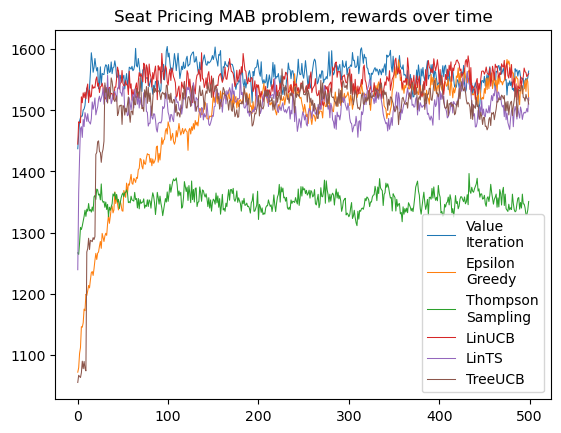

In [21]:
# --- Run multiple episodes; average per round
nr_episodes = 2500
episode_length = 500

t0 = time.time()
value_rewards = run_contextual_bandit(value_agent, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"Value iteration, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(value_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(value_rewards)).__round__(2))

t0 = time.time()
eps_rewards = run_contextual_bandit(eps_greedy, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"Epsilon greedy, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(eps_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(eps_rewards)).__round__(2))

t0 = time.time()
ts_rewards = run_contextual_bandit(thompson_sampling, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"Thompson Sampling, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(ts_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(ts_rewards)).__round__(2))

t0 = time.time()
lin_ucb_rewards = run_contextual_bandit(lin_ucb, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"LinUCB, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(ts_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(ts_rewards)).__round__(2))

t0 = time.time()
lin_ts_rewards = run_contextual_bandit(lin_ts, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"LinTS, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(ts_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(ts_rewards)).__round__(2))

t0 = time.time()
tree_ucb_rewards = run_contextual_bandit(tree_ucb, mab, context_grid, episodes=nr_episodes, 
                                    episode_length=episode_length, initial_context=None, random_start=True)
t1 = time.time()

print(f"TreeUCB, simulated {nr_episodes} episodes x {episode_length} rounds in {t1-t0:.2f}s")
print("Avg revenue per round (first 12):", np.round(ts_rewards[:12], 2))
print("Overall average revenue/round:", float(np.mean(ts_rewards)).__round__(2))

chart_data = [np.array(value_rewards), np.array(eps_rewards), np.array(ts_rewards), 
              np.array(lin_ucb_rewards), np.array(lin_ts_rewards), np.array(tree_ucb_rewards)]
chart_titles = ["Value\nIteration", "Epsilon\nGreedy", "Thompson\nSampling", "LinUCB", "LinTS", "TreeUCB"]
chart_name = "Seat Pricing MAB problem, rewards over time"
show_rewards_chart_over_time(chart_data, chart_titles, chart_name)

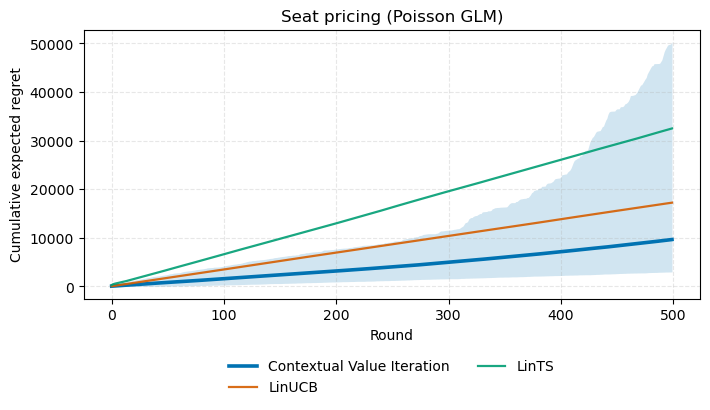

In [22]:
curves = collect_cumulative_expected_regret(mab, [value_agent, lin_ucb, lin_ts],
                                            n_rounds=episode_length, n_simulations=nr_episodes)

plot_learning_curves_with_ci(
    curves_dict=curves,
    show_only=["Contextual Value Iteration", "LinUCB", "LinTS"],
    highlight="Contextual Value Iteration",
    band_type="ci",
    bands_for="highlight",
    smooth_window=0,
    ylabel="Cumulative expected regret",
    title="Seat pricing (Poisson GLM)",
    save_prefix="cummulative-regret"
)

Algorithms: ['Epsilon Greedy', 'ContextualTS', 'LinTS', 'LinUCB', 'Tree-UCB', 'Contextual Value Iteration']
Average regrets: [48980.65092940802, 114569.81967524004, 34701.541706705466, 17111.34106739926, 35940.90251327994, 10464.34667880834]
95% empirical CI lower: [11015.702940642659, 86923.29441302738, 11158.920672901797, 10569.32581847564, 2547.993570100225, 2982.7056273105536]
95% empirical CI upper: [120753.05146103051, 142965.74558369216, 248323.996255505, 23230.826020048953, 173913.23526406125, 67103.88437579306]
Run times: [datetime.timedelta(seconds=40, microseconds=112686), datetime.timedelta(seconds=107, microseconds=688119), datetime.timedelta(seconds=90, microseconds=72356), datetime.timedelta(seconds=61, microseconds=438981), datetime.timedelta(seconds=1130, microseconds=346462), datetime.timedelta(seconds=49, microseconds=559740)]


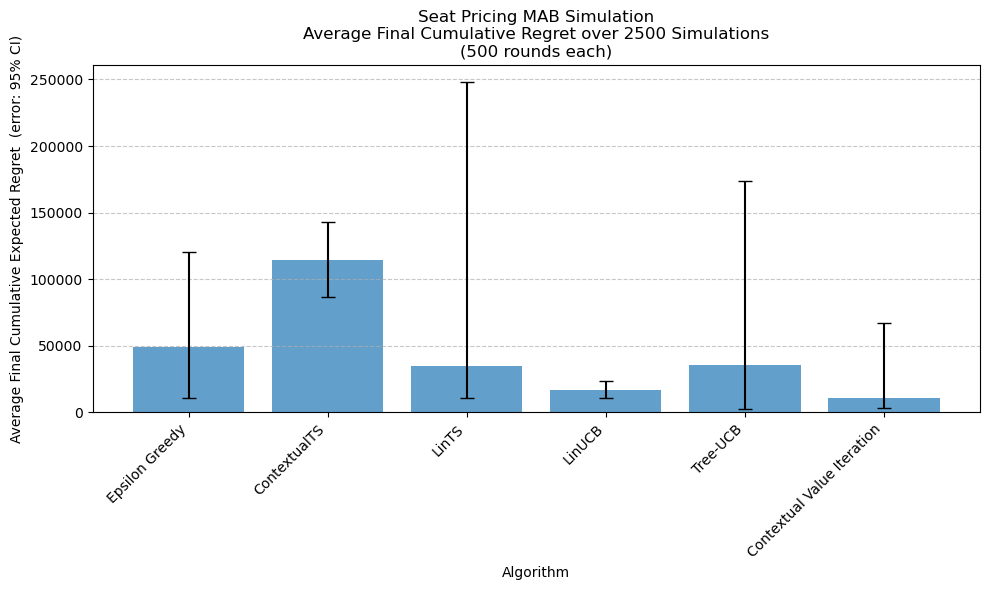

Running time: 0:24:39.368116


In [23]:
agents = [eps_greedy, thompson_sampling, lin_ts, lin_ucb, tree_ucb, value_agent]
start_time = datetime.now()
run_bandits(mab, agents, n_rounds=500, n_simulations=2500, title='Seat Pricing MAB Simulation\n', regret_mode="expected",  # or "realized"
                      save_prefix="pricing_expected_regret", error_style='confidence-interval')
end_time = datetime.now()
print('Running time: {}'.format(end_time - start_time))

# Deep Value Iteration against benchmark

### Problem set-up

In [24]:
random_value = 42

env = AILCBanditEnv(n_arms=20, context_dim=10, random_state=random_value)

samples = get_warmup_samples(env, 100)
context_dims = len(env.get_context())

arm_count = env.get_nr_arms()
arms = np.arange(arm_count)


### Deep Value Iteration initialisation

In [25]:
start_time_attention = datetime.now()
deep_value_iteration = BetaValueIterationNN(arms=arms, max_iterations=500, context_dim=context_dims,
                                                 replay_buffer_size=1000, online_batch_size=32,
                                                 random_state=random_value, calculate_value_function=True)
deep_value_iteration.warmup_value_function(samples, num_epochs=50)
end_time_attention = datetime.now()
print('Training time value iteration with context: {}'.format(end_time_attention - start_time_attention))

[Offline] Iteration 0/500, Loss: 0.3763
[Offline] Iteration 10/500, Loss: 0.3685
[Offline] Iteration 20/500, Loss: 0.2773
[Offline] Iteration 30/500, Loss: 0.1873
[Offline] Iteration 40/500, Loss: 0.1425
[Offline] Iteration 50/500, Loss: 0.1749
[Offline] Iteration 60/500, Loss: 0.1416
[Offline] Iteration 70/500, Loss: 0.1482
[Offline] Iteration 80/500, Loss: 0.1422
[Offline] Iteration 90/500, Loss: 0.1434
[Offline] Iteration 100/500, Loss: 0.1217
[Offline] Iteration 110/500, Loss: 0.1205
[Offline] Iteration 120/500, Loss: 0.1242
[Offline] Iteration 130/500, Loss: 0.1261
[Offline] Iteration 140/500, Loss: 0.1183
[Offline] Iteration 150/500, Loss: 0.1000
[Offline] Iteration 160/500, Loss: 0.0783
[Offline] Iteration 170/500, Loss: 0.0494
[Offline] Iteration 180/500, Loss: 0.0333
[Offline] Iteration 190/500, Loss: 0.0154
[Offline] Iteration 200/500, Loss: 0.0075
[Offline] Iteration 210/500, Loss: 0.0019
[Offline] Iteration 220/500, Loss: 0.0016
[Offline] Iteration 230/500, Loss: 0.0015
[Of

### Benchmark algorithm initialisation

In [26]:
lin_ucb     = LinUCB(arms, context_dim=context_dims, alpha=1.0)
lin_ts      = LinTS(arms, context_dim=context_dims, lam=1.0, v=1.0)
tree_ucb    = TreeUCB(arms, context_dim=context_dims)

### Run algorithms on contextual bandit problem

Algorithms: ['LinUCB', 'LinTS', 'Tree-UCB', 'Deep-Value-Iteration']
Average regrets: [1908.1709278919338, 1916.9097775404389, 1778.7379862141001, 847.2921311014652]
95% empirical CI lower: [1872.342567340849, 1886.4074599178991, 1675.4720400034862, 4.3964778625960435]
95% empirical CI upper: [2073.1474898947995, 1958.4928383050783, 1878.1820855821468, 1414.5079107447666]
Run times: [datetime.timedelta(seconds=19, microseconds=369148), datetime.timedelta(seconds=27, microseconds=432470), datetime.timedelta(seconds=972, microseconds=513935), datetime.timedelta(seconds=950, microseconds=875961)]


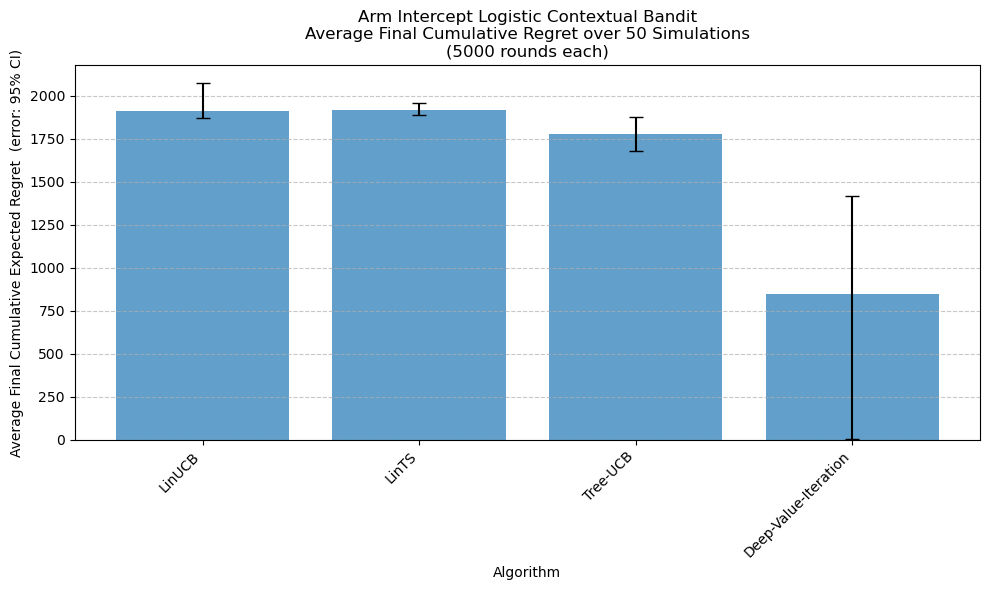

Running time: 0:32:50.345970


In [28]:
agents = [lin_ucb, lin_ts, tree_ucb, deep_value_iteration]
start_time = datetime.now()
run_bandits(env, agents, n_rounds=5000, n_simulations=50, title='Arm Intercept Logistic Contextual Bandit\n',
            regret_mode="expected", save_prefix="synthetic_expected_regret", error_style='confidence-interval')
end_time = datetime.now()
print('Running time: {}'.format(end_time - start_time))